<font size=6 color='violet'>Introduction</font>

![](http://www.gpb.org/sites/www.gpb.org/files/styles/hero_image/public/blogs/images/2018/08/07/maxresdefault.jpg?itok=gN6ErLyU)




In this dataset, we are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment. Each application install is represented by an installation_id. This will typically correspond to one child, but you should expect noise from issues such as shared devices. In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

    3: the assessment was solved on the first attempt
    2: the assessment was solved on the second attempt
    1: the assessment was solved after 3 or more attempts
    0: the assessment was never solved



<font color='blue' size=4>If you think this kernel was helpful,please don't forget to click on the upvote button,that helps a lot.</font>

##  <font size=5 color='violet'> Importing required libraries</font>

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mode
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# import shap


### <font size=4 color='violet'> Reading and understanding our data</font>

In [3]:
os.listdir('../input/data-science-bowl-2019')


FileNotFoundError: [Errno 2] No such file or directory: '../input/data-science-bowl-2019'

In [5]:
%%time
keep_cols = ['event_id', 'game_session', 'installation_id', 'event_count',
             'event_code','title' ,'game_time', 'type', 'world','timestamp']
train=pd.read_csv('train.csv',usecols=keep_cols)
train_labels=pd.read_csv('train_labels.csv',
                         usecols=['installation_id','game_session','accuracy_group'])
test=pd.read_csv('test.csv',usecols=keep_cols)
submission=pd.read_csv('sample_submission.csv')

CPU times: user 33.8 s, sys: 3.23 s, total: 37 s
Wall time: 1min 7s


We can see that this data contains full history of the installation,ie each time a child has played the game a unique game_session identifier is generated and the attributes related to the game is stored.The atttributes are:

The data provided in these files are as follows:
- `event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
- `timestamp` - Client-generated datetime
- `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise - fields are determined by the event type.
- `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- `event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- `game_time` - Time in milliseconds since the start of the game session. Extracted from event_data.
- `title` - Title of the game or video.
- `type` - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media.

 We will not consider `specs.csv`,it contains description of events in natural language.

In [6]:
train.shape,train_labels.shape

((11341042, 10), (17690, 3))

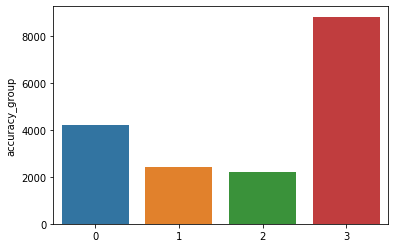

In [7]:
x=train_labels['accuracy_group'].value_counts()
sns.barplot(x.index,x)

## <font size=5 color='violet'> Data Preparation</font>

In this we will prepare the data and make it in a trainable form.For that we will do the following steps :
- first,we will find the installation ids which are in `train.csv` and which are not in `train_labels.csv`.These installations won't  be of much use to us because `train_labels.csv` contains the the target label,ie `accuracy group`.We will first identify them and remove those rows.

In [8]:
not_req=(set(train.installation_id.unique()) - set(train_labels.installation_id.unique()))

In [9]:
train_new=~train['installation_id'].isin(not_req)
train.where(train_new,inplace=True)
train.dropna(inplace=True)
train['event_code']=train.event_code.astype(int)

<font size=3 color='violet'>Extracting time features</font>


In [10]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    return df

Next,we will define a `prepare_data` funtion to prepare our train and test data.For the we will do the following steps:
-   extract `hour_of_day` from timestamp and drop timestamp column,this indicated the hour of day in which is child playes the game.
-   We will do an on_hot encoding on `event_code` and group the dataframe by installation_id and game_session.
-   We will define an `agg` dictionary to define the the aggregate functions to be performed after grouping the dataframe
-   For variables 'type','world' and 'title' we will the the first value,as it is unique for every installation_id,game_session pair.
-   Atlast, we will join all these togethor and return the dataframe.


In [11]:
time_features=['month','hour','year','dayofweek','weekofyear']
def prepare_data(df):
    df=extract_time_features(df)
    
    df=df.drop('timestamp',axis=1)
    #df['timestamp']=pd.to_datetime(df['timestamp'])
    #df['hour_of_day']=df['timestamp'].map(lambda x : int(x.hour))
    

    join_one=pd.get_dummies(df[['event_code','installation_id','game_session']],
                            columns=['event_code']).groupby(['installation_id','game_session'],
                                                            as_index=False,sort=False).agg(sum)

    agg={'event_count':sum,'game_time':['sum','mean'],'event_id':'count'}

    join_two=df.drop(time_features,axis=1).groupby(['installation_id','game_session']
                                                   ,as_index=False,sort=False).agg(agg)
    
    join_two.columns= [' '.join(col).strip() for col in join_two.columns.values]
    

    join_three=df[['installation_id','game_session','type','world','title']].groupby(
                ['installation_id','game_session'],as_index=False,sort=False).first()
    
    join_four=df[time_features+['installation_id','game_session']].groupby(['installation_id',
                'game_session'],as_index=False,sort=False).agg(mode)[time_features].applymap(lambda x: x.mode[0])
    
    join_one=join_one.join(join_four)
    
    join_five=(join_one.join(join_two.drop(['installation_id','game_session'],axis=1))). \
                        join(join_three.drop(['installation_id','game_session'],axis=1))
    
    return join_five



In [15]:

join_train=prepare_data(train)
cols=join_train.columns.to_list()[2:-3]
join_train[cols]=join_train[cols].astype('int16')



In [12]:
join_test=prepare_data(test)
cols=join_test.columns.to_list()[2:-3]
join_test[cols]=join_test[cols].astype('int16')

In this step,we will 
-  prepare train by merging  our train to train_labels.This will be our `final_train`.
-  prepare the test by selecting last row of each installation_id ,game_session as we have only 1000 rows in `sample_submission`.The last accuracy group for each installation id is taken as the accuracy group of the child.


In [13]:
cols=join_test.columns[2:-12].to_list()
cols.append('event_id count')
cols.append('installation_id')

- It seems that  we have to group dafaframe by `installation_id` to form a proper trainable dataframe.
- We will apply the same to form out test set.

In [20]:
df=join_test[['event_count sum','game_time mean','game_time sum',
    'installation_id']].groupby('installation_id',as_index=False,sort=False).agg('mean')

df_two=join_test[cols].groupby('installation_id',as_index=False,
                               sort=False).agg('sum').drop('installation_id',axis=1)

df_three=join_test[['title','type','world','installation_id']].groupby('installation_id',
         as_index=False,sort=False).last().drop('installation_id',axis=1)

df_four=join_test[time_features+['installation_id']].groupby('installation_id',as_index=False,sort=False). \
        agg(mode)[time_features].applymap(lambda x : x.mode[0])


KeyError: 'installation_id'

In [17]:
final_train=pd.merge(train_labels,join_train,on=['installation_id','game_session'],
                                         how='left').drop(['game_session'],axis=1)

#final_test=join_test.groupby('installation_id',as_index=False,sort=False).last().drop(['game_session','installation_id'],axis=1)
final_test=(df.join(df_two)).join(df_three.join(df_four)).drop('installation_id',axis=1)

In [21]:
df_two

,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,event_code_2060,event_code_2070,...,event_code_4090,event_code_4095,event_code_4100,event_code_4110,event_code_4220,event_code_4230,event_code_4235,event_code_5000,event_code_5010,event_id count
0,26,1,11,1,7,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,868
1,58,4,85,2,80,2,6,6,4,1,...,2,0,23,3,9,0,0,4,4,2719
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,150
3,14,0,3,2,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,234
4,25,0,28,9,25,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9,2,8,2,6,1,0,0,0,0,...,0,1,2,1,0,0,0,0,0,212
996,17,1,7,0,7,0,0,0,2,0,...,0,2,1,0,0,0,0,0,0,303
997,39,3,6,1,5,1,0,0,0,0,...,0,0,9,0,0,0,0,0,0,526
998,19,0,6,0,2,0,0,0,1,0,...,2,0,6,0,0,0,0,0,0,259


In [18]:
df=final_train[['event_count sum','game_time mean','game_time sum','installation_id']]. \
    groupby('installation_id',as_index=False,sort=False).agg('mean')

df_two=final_train[cols].groupby('installation_id',as_index=False,
                                 sort=False).agg('sum').drop('installation_id',axis=1)

df_three=final_train[['accuracy_group','title','type','world','installation_id']]. \
        groupby('installation_id',as_index=False,sort=False). \
        last().drop('installation_id',axis=1)

df_four=join_train[time_features+['installation_id']].groupby('installation_id',as_index=False,sort=False). \
        agg(mode)[time_features].applymap(lambda x : x.mode[0])



final_train=(df.join(df_two)).join(df_three.join(df_four)).drop('installation_id',axis=1)

KeyError: 'installation_id'

In [22]:
final_train.shape,final_test.shape

((17690, 56), (1000, 54))

Just making sure that all the columns in our `final_train` and `final_test` is the same,except accuracy_group.The instersection should return `54`.

In [23]:
len(set(final_train.columns) & set(final_test.columns))

54

YES ! It's done..

## <font size=4 color='violet'> Label Encoding</font>
- We will concat out final_train and final_test to form `final`.
- We will label encode the categorical variables.
- We will split them back to final_train and final_test.

In [24]:
final=pd.concat([final_train,final_test])
encoding=['type','world','title']
for col in encoding:
    lb=LabelEncoder()
    lb.fit(final[col])
    final[col]=lb.transform(final[col])
    
final_train=final[:len(final_train)]
final_test=final[len(final_train):]


    


/home/kurian/Kaggle/DSbowl/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [25]:
X_train=final_train.drop('accuracy_group',axis=1)
y_train=final_train['accuracy_group']

<font size=5 color='violet'>Evaluation</font>

Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.

$$w_{i,j} = \frac{\left(i-j\right)^2}{\left(N-1\right)^2}$$

We will use `cohen_kappa_score` which is available in `sklearn.metrics` to calculate the score.

## <font size=5 color='violet'> XGBoost with StratifiedKFold</font>

Here we will use `StratifiedKFold` and `xgboost` model to train and make prediction.


In [26]:
def model(X_train,y_train,final_test,n_splits=3):
    scores=[]
    pars = {
        'colsample_bytree': 0.8,                 
        'learning_rate': 0.08,
        'max_depth': 10,
        'subsample': 1,
        'objective':'multi:softprob',
        'num_class':4,
        'eval_metric':'mlogloss',
        'min_child_weight':3,
        'gamma':0.25,
        'n_estimators':500
    }

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pre=np.zeros((len(final_test),4),dtype=float)
    final_test=xgb.DMatrix(final_test.drop('accuracy_group',axis=1))


    for train_index, val_index in kf.split(X_train, y_train):
        train_X = X_train.iloc[train_index]
        val_X = X_train.iloc[val_index]
        train_y = y_train[train_index]
        val_y = y_train[val_index]
        xgb_train = xgb.DMatrix(train_X, train_y)
        xgb_eval = xgb.DMatrix(val_X, val_y)

        xgb_model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=1000,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=False,
                      early_stopping_rounds=20
                     )

        val_X=xgb.DMatrix(val_X)
        pred_val=[np.argmax(x) for x in xgb_model.predict(val_X)]
        score=cohen_kappa_score(pred_val,val_y,weights='quadratic')
        scores.append(score)
        print('choen_kappa_score :',score)

        pred=xgb_model.predict(final_test)
        y_pre+=pred

    pred = np.asarray([np.argmax(line) for line in y_pre])
    print('Mean score:',np.mean(scores))
    
    return xgb_model,pred

In [31]:
X_train = X_train.drop('installation_id',axis=1)

In [33]:
X_train

,dayofweek,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,event_code_2060,...,event_id count,game_time mean,game_time sum,hour,month,title,type,weekofyear,world,year
0,1,1,1,1,1,1,1,0,0,0,...,35,10131.0,26928.0,5,8,4,0,32,2,2019
1,1,1,0,1,0,0,0,0,0,0,...,87,-17765.0,27366.0,5,8,0,0,32,2,2019
2,1,1,1,1,1,1,1,0,0,0,...,48,17534.0,-10305.0,5,8,4,0,32,2,2019
3,1,1,1,1,1,1,1,0,0,0,...,42,12633.0,6334.0,20,8,4,0,32,2,2019
4,1,1,1,2,0,2,0,0,0,0,...,32,17318.0,29907.0,20,8,0,0,32,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17685,0,1,1,2,0,2,0,0,0,0,...,48,29210.0,25842.0,21,7,0,0,31,2,2019
17686,2,1,1,2,0,2,0,0,0,0,...,40,27651.0,-8034.0,1,8,2,0,32,1,2019
17687,6,1,1,2,0,2,0,0,0,0,...,61,-28155.0,-13501.0,2,9,2,0,38,1,2019
17688,6,1,0,1,1,0,1,0,0,0,...,97,-9887.0,24095.0,1,9,4,0,38,2,2019


In [37]:
xgb_model,pred=model(X_train,y_train,final_test,5)

/home/kurian/Kaggle/DSbowl/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


choen_kappa_score : 0.9988370540070258
choen_kappa_score : 0.998389590041373
choen_kappa_score : 0.998389590041373
choen_kappa_score : 0.9991949616257962
choen_kappa_score : 0.9982106556920216
Mean score: 0.9986043702815179


In [35]:
final_test = final_test.drop('installation_id', axis=1)

In [36]:
final_test

,accuracy_group,dayofweek,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,...,event_id count,game_time mean,game_time sum,hour,month,title,type,weekofyear,world,year
0,NaN,1,26,1,11,1,7,0,0,0,...,868,1039.923077,-184.653846,16,9,2,0,37,1,2019
1,NaN,6,58,4,85,2,80,2,6,6,...,2719,437.413793,1804.137931,21,9,1,0,38,0,2019
2,NaN,5,9,0,0,0,0,0,0,0,...,150,-6865.777778,-3127.888889,11,9,4,0,38,2,2019
3,NaN,5,14,0,3,2,3,0,0,0,...,234,-1541.357143,-4800.642857,16,7,4,0,30,2,2019
4,NaN,3,25,0,28,9,25,0,0,0,...,952,-3121.840000,-2531.600000,15,8,1,0,33,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,5,9,2,8,2,6,1,0,0,...,212,4361.333333,-702.111111,1,9,2,0,39,1,2019
996,NaN,6,17,1,7,0,7,0,0,0,...,303,784.235294,-1.705882,17,10,3,0,41,0,2019
997,NaN,0,39,3,6,1,5,1,0,0,...,526,3269.794872,-1623.256410,23,7,1,0,31,0,2019
998,NaN,1,19,0,6,0,2,0,0,0,...,259,1567.473684,2221.684211,18,9,1,0,37,0,2019


## <font size=5 color='violet'> Making our submission</font>

After making our prediction we will make our submission to `submission.csv`.

In [38]:
sub=pd.DataFrame({'installation_id':submission.installation_id,'accuracy_group':pred})
sub.to_csv('submission.csv',index=False)


## <font size=5 color='violet'>Feature Selection</font>

We will use    module of xgboost to plot the feature importances and see what features  our model think are important for making prediction.


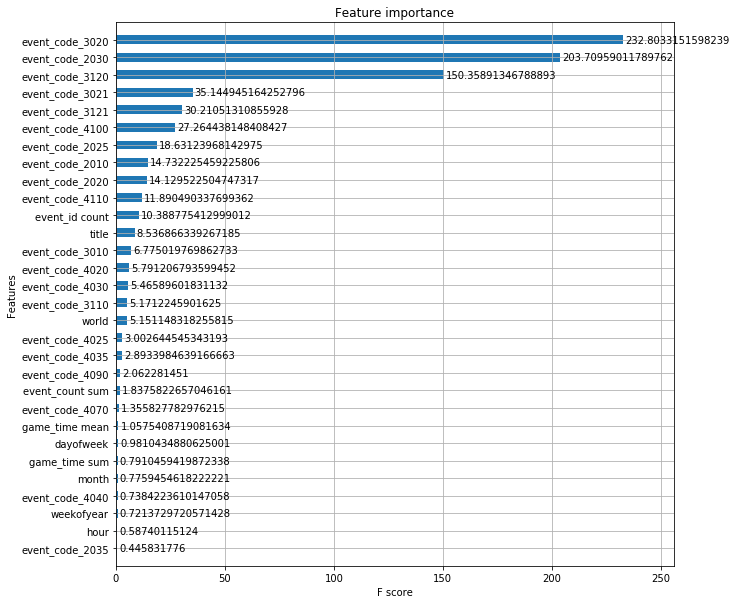

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

There are three methods to measure feature_importances in xgboost.They are :
- `weight` : The total number of times this feature was used to split the data across all trees.
- `Cover` :The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- `Gain` : The average loss reduction gained when using this feature for splitting in trees.

We used `Gain` in the above example and the model says when it used `event_code_2030` the loss on average was reduced by 8%.

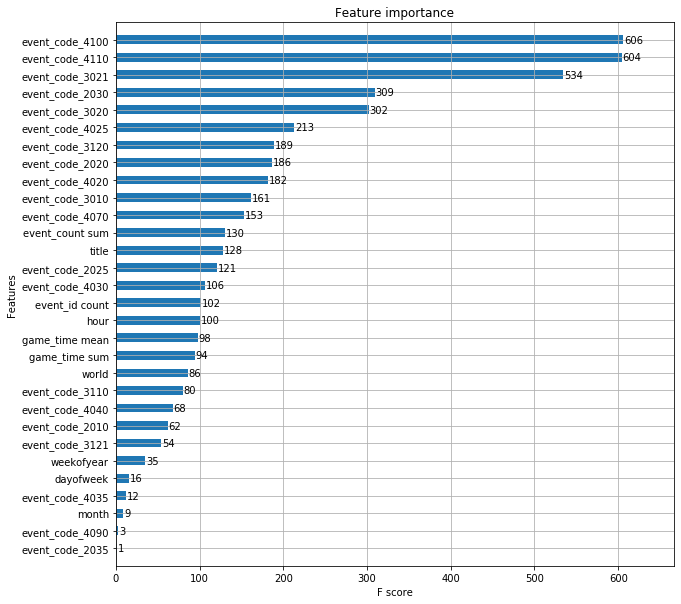

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax,importance_type='weight')
plt.show()

When we considered weight,the model says that is used `game_time mean` 1035 times to split the data across the trees.

hmmm...so how what can we conclude from above figures?
We will find out....

### <font size=4 color='violet'>Interpreting our model with Confidence</font>



`SHAP` is a powerful tool for interpreting our model with more confidence,It makes the process simple and understandable.We will try SHAP in this section for interpret our model.

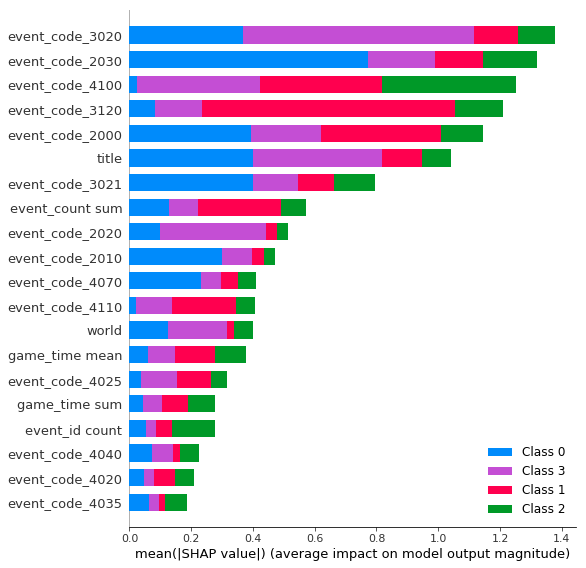

In [25]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

For example,this figure expains the feature importance and it's influence on different class.
- for feature `event_code_3020` its SHAP value is high for `class 3` means it influences predicting class 3 is more than any other class.

Summary plot for `class 3`

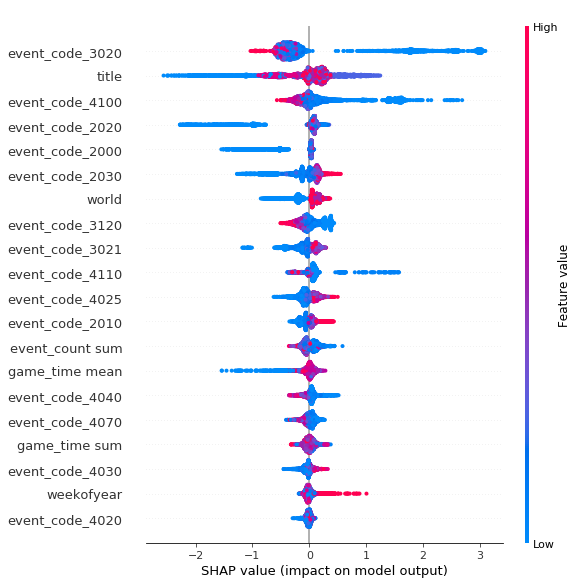

In [26]:
shap.summary_plot(shap_values[3], X_train)

Here we can see that the variables are ranked in the descending order.
- The most important variable `event_code_3020`.
- Lower value of `event_code_3020` has a high and positive impact on the model predicting `class 3` .
- Lower value of `event_code_3020` the model tends to classify it to `class 3`

Similarly for `class0`

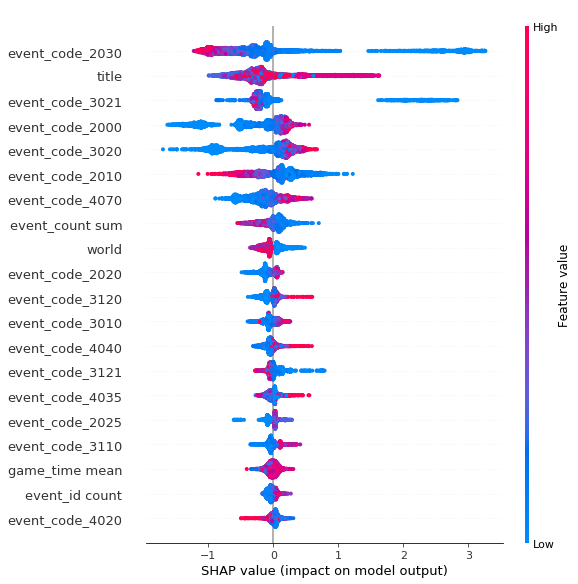

In [27]:
shap.summary_plot(shap_values[0], X_train)

Hope you can see the differnce between them.

### <font size=4 color='violet'>Select from Features</font>

We will use sklearn `SelectFromFeatures` to select relevent features.

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
threshold = np.sort(model.feature_importances_)[40:]
for thresh in threshold:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = cohen_kappa_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, cohen kappa score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    
    
    

Thresh=0.000, n=14, cohen kappa score: 99.83%
Thresh=0.001, n=13, cohen kappa score: 99.83%
Thresh=0.003, n=12, cohen kappa score: 99.83%
Thresh=0.006, n=11, cohen kappa score: 99.83%
Thresh=0.010, n=10, cohen kappa score: 99.83%
Thresh=0.011, n=9, cohen kappa score: 99.83%
Thresh=0.013, n=8, cohen kappa score: 98.10%
Thresh=0.016, n=7, cohen kappa score: 98.10%
Thresh=0.020, n=6, cohen kappa score: 95.27%
Thresh=0.031, n=5, cohen kappa score: 95.27%
Thresh=0.035, n=4, cohen kappa score: 93.58%
Thresh=0.159, n=3, cohen kappa score: 91.49%
Thresh=0.290, n=2, cohen kappa score: 91.41%
Thresh=0.403, n=1, cohen kappa score: 63.35%


We need to look into it further and evaluate...

### Under Construction!!!

<font color='red' size=4>If you think this kernel was helpful,please don't forget to click on the upvote button,that helps a lot.</font>